# 2469117b Portfolio Notebook for AI for the Arts B
## <a href="https://github.com/AlexanderBroad/AI_B">Github Repository</a>

# <u><b>First, please run the cell below to import the necessary dependencies for the Presentation:</b></u>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import shutil
import glob
import json
import collections
import tensorflow as tf
import numpy as np
import librosa
import random
from scipy.stats import entropy
import keras
from keras.models import Model, load_model
import keras.backend as K
from keras.applications.mobilenet import MobileNet
from keras.utils import load_img, img_to_array
from IPython.display import Audio, Image, display_jpeg, display
import librosa.display
print("Thank you!")

# <u>Context</u>

## <u>The object, history, and objectives</u>

The object chosen for my project is <b>MS Gen 13</b>, a late nineteenth century travel journal. The journal is located in the University of Glasgow's Special Collections. Full archival details are available <a href="https://www.gla.ac.uk/collections/#/details?irn=250262&catType=C&referrer=/results&q=ms+gen+13">here.</a> Written by Glasgow lawyer Andrew MacGeorge, the journal chronicles a contintental tour the family undertook during the winter of 1867-1868, also containing some pen and ink illustrations and photographs of scenes from the holiday.
<br><br>
I chose this object as I felt that out of all the objects available to us, it had the most potential for Human-AI creative collaboration. The objective of the project is to engage a general audience with cultural heritage with the use of generative AI. Specifically, I was interested in using the sketches in the journal to create an engaging tool that could be implemented as an exhibit in a gallery/museum setting where users can read the journal and view MacGeorge's sketches, accompanied by AI-generated soundscapes relating to each sketch. Additionally, I wanted users to be able to upload their own images and have generative AI convert them into the style of MacGeorge's illustrations.
<br><br>
The objectives behind the project were:
<ul> Allowing users to see their own images in the style of Macgeorge's sketches to give them a deeper appreciation of what it was like to travel long distances in the nineteenth century. </ul>
<ul> Accompanying Macgeorge's sketches with soundscapes to increase their overall appeal, increase user engagement, and broaden users' understanding of social and class differences in the past that meant holidaying abroad was only possible for the very wealthy, like Andrew Macgeorge and his family. </ul>
<ul> Adding soundcapes to the images to increase inclusivity as they have the potential to engage partially-sighted users with the journal. </ul>
<br>
When undertaking initial research on the generative AI processes needed to meet my objectives, I made the decision to focus my efforts on the soundscape feature, as I felt the image-style generation element would increase the scope of the project too much for the timeframe of the course. Additionally I thought that in terms of cultural engagement the soundscape feature was more conducive to highlighting the social perspective the journal gives.

# <u>Methodology</u>

## <u>Incorporating generative AI models</u>

Initially my intention for implementing an AI-generated soundscape was to use two models in conjuction: a model for image classification to identify elements of an image; and a text-to-audio model to generate sounds, using the output of the first model as its input. In terms of Human-AI collaboration, human creativity is present in the form of MacGeorge's sketches, which provide the input for the image classification model, whereas the AI component is found in both the image classification model and in the text-to-audio model. Two issues arose when experimenting with this proposed workflow. The first was the innacuracy of image classification models when identifying objects in the sketches from the journal. The second issue was the viability of text-to-audio models for building a soundscape. I found that currently available text-to-audio models were unsuitable for producing long-length audio files needed for a soundscape, and generally performed better when generating short-length audio files.
<br><br>
To overcome the first challenge I used "Sketch to image", an app from <a href="https://openart.ai/home">Open Art</a> to upscale the journal sketches to allow an image classification model to better identify the elements in them:
![upscaling example](images/upscaling_example.jpg)
<br><br>
The second issue was overcome with the use of <a href="https://qosmo.jp/en/art/imaginarysoundscape"><b>Imaginary Soundscape</b></a>, a project by <a href="https://qosmo.jp/en">Qosmo AI Creativity & Music Lab</a>. This model "imagines" a soundscape from an image by matching sounds to that image. Specifically, two Convolutional Neural Networks (CNNs) are utilized. CNNs are a type of neural network often used in computer vision applications. They contain hidden layers that can recognise and differentiate features in an image, as well as determine the relative importance of features. One CNN (based on MIT's <a href="http://soundnet.csail.mit.edu/">SoundNet</a>) is trained to extract audio features from a dataset of unlabeled video, creating a database of environmental sounds. Another CNN extracts visual features from an image, then matches them to the most appropriate sound from the database.
<br>

### <u>Diagram of the Model from the Imaginary Soundscape paper:</u>
![Model](https://github.com/Kajiyu/ImaginarySoundscapeDemo/raw/master/assets/model.jpg)
Credit: "Imaginary Soundscape: Cross-Modal Approach to Generate Pseudo Sound Environments" by Yuma Kajihara, Shoya Dozono, Nao Tokui

Through this process, the interaction between AI and humans can be observed. Humans create the dataset of environmental sounds by recording sound and video of the real world, forming the training data for the Audio CNN. Additonally we supply the vast dataset of images upon which the Visual CNN trains, and we capture (or in this case draw) the image on which the soundscape is based. AI matches features extracted from these elements to select a sound that best matches what MacGeorge drew. Finally, humans engage with the journal by reading it, viewing the sketches and listening to their associated soundscapes. In this way, my approach meets the objectives stated earlier.

# <u>Presentation</u>

The following presentation is based on the Imaginary Soundscape demo code, available at: https://github.com/QosmoInc/ImaginarySoundscapeDemo

## <u>Before you try...</u>
Please download this <a href="https://github.com/Kajiyu/ImaginarySoundscapeDemo/releases/download/v1.0.0/data.zip">zipped data file</a> and unzip it into the same directory as this notebook. Thank you!


## <u>1. Please run the following five cells to define the functions needed for preprocessing of images, feature extraction, and selecting sounds.</u>

In [ ]:
## This code defines a function that normalises, shifts, and scales up the values of pixels in an image.
## This is all the image preprocessing needed for our purposes.
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [ ]:
## This code defines a function that extracts features from an image using a pre-trained model, ImageNet.
def get_image_features(model, filepath):
    img = load_img(filepath, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_image(x)
    preds = model.predict(x)[0]
    return preds

In [ ]:
## This code defines a function that loads an audio file, scales it up and normalises it, then extracts features from it using the pre-trained SoundNet model.
def get_sound_features(model,filepath):
    x, sr = librosa.load(filepath)
    x = x * 255.0
    x = np.reshape(x, (1, x.shape[0], 1, 1))
    x[x < -255.] = -255.
    x[x > 255.] = 255.
    assert np.max(x) < 256., "It seems this audio contains signal that exceeds 256"
    assert np.min(x) > -256., "It seems this audio contains signal that exceeds -256 " + str(np.min(x)) + " : " + filepath
    _y_pred = model.predict(x)
    feature =  _y_pred[0][0][0][0]
    return feature

In [ ]:
## This code defines a function that matches the features extracted from the image and sound files to give the top 'k' songs most similar to the image, where 'k' is an integer specifying the number of songs to return. 
def get_topk_songs(img_feature, song_features, k=3):
    distances = []
    for i in range(len(song_features)):
        distance = entropy(img_feature, song_features[i])
        distances.append(distance)
    topk_indecies = np.argsort(distances)[:k]
    return topk_indecies

In [ ]:
## This code defines a function with two outputs: a JSON file containing information about sound files, and a numpy file containing features extracted from the sound files.
def create_sound_libs(
    soundnet_model,
    query="./data/sound_samples/*.mp3",
    out_json_path="./data/sounds.json",
    out_npy_path='./data/song_features.npy'
):
    mp3_files = glob.glob(query)
    output_dict = {"mp3":[]}
    for i in range(len(mp3_files)):
        x, sr = librosa.load(mp3_files[i])
        if len(x) > 230000:
            output_dict["mp3"].append({"filepath":mp3_files[i], "index":str(i)})
    with open(out_json_path, "w")  as f:
        json.dump(output_dict, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    song_features = []
    for item in output_dict["mp3"]:
        i_feature = get_sound_features(soundnet_model,item['filepath'])
        song_features.append(i_feature)
    song_features = np.array(song_features)
    print("Sound npy shape:", song_features.shape)
    np.save(out_npy_path, song_features)
    return (output_dict, song_features)

## 2. <u>Load SoundNet and ImageNet models by running the following cell:</u>

In [61]:
soundnet = load_model("./data/models/soundnet.hdf5")
imagenet = MobileNet(include_top=True, weights='imagenet')

## <u>3. Create sound features using SoundNet model by running the cell below:</u>

- npy file: features of sounds pre-calculated by SoundNet
- json file: including ...
    - filepath: the path of each sound file
    - index: the index of each sound file at the npy array

In [57]:
# create sound features using SoundNet model
(mp3_files, sound_features) = create_sound_libs(soundnet)

print("#of mp3 files", len(mp3_files['mp3']))

1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 120ms/step
Sound npy shape: (268, 1000)
#of mp3 files 268


or

In [ ]:
# or, load pre-processed json data
with open("./data/sounds.json") as f:
    mp3_files = json.load(f)
sound_features = np.load("./data/song_features.npy")

## 3. Find the best-matched sound files for an input image

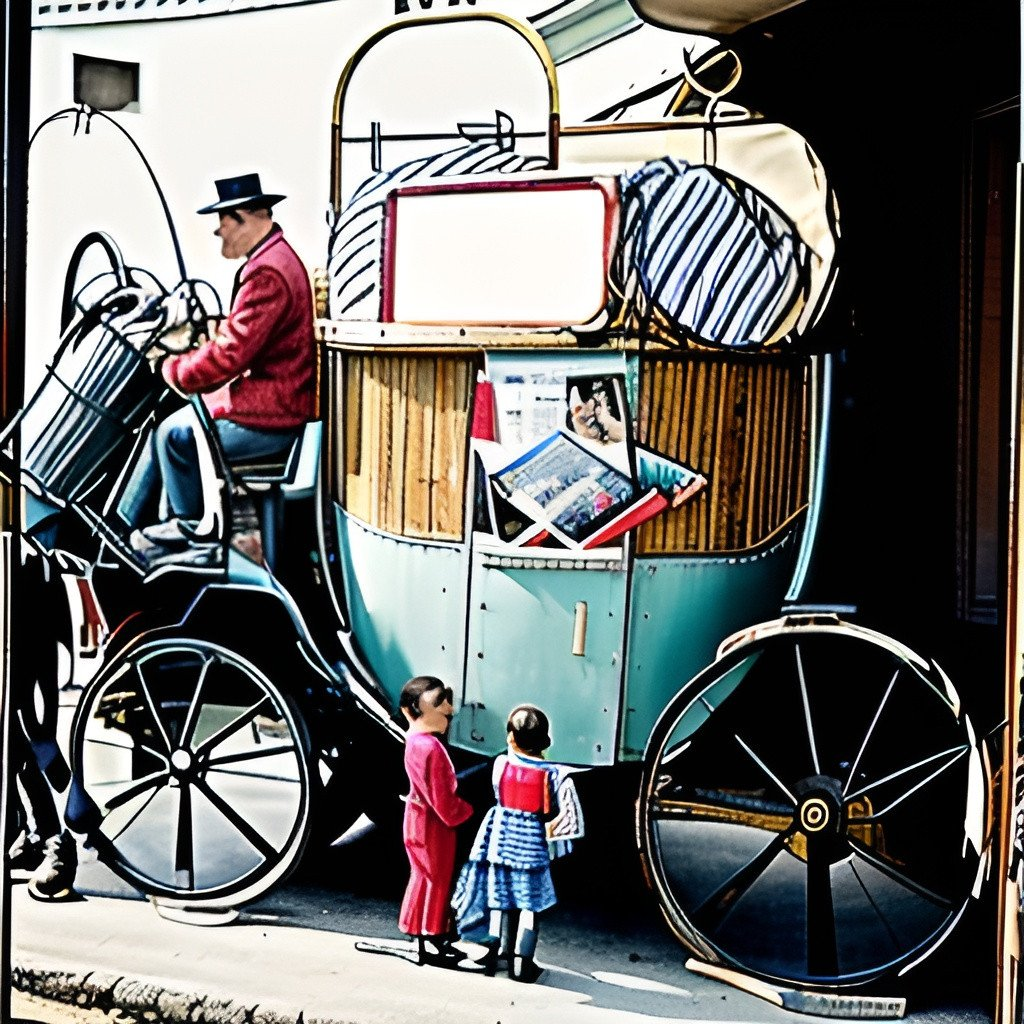

In [59]:
IMG_PATH = "./images/carriage_upscaled.jpg"
display_jpeg(Image(IMG_PATH))

In [62]:
# Extract image features using ImageNet model(MobileNet)
img_feature = get_image_features(imagenet, IMG_PATH)

# Match the image features and pre-processed sound features,
# then find the topK best matched sound files 
topk_indecies = get_topk_songs(img_feature, sound_features, k=3)

1/1 [==============================] - 0s 364ms/step


In [63]:
print("The best-matched sound:")
print

for i in range(3):
    print("Top #", i)
    display(Audio(mp3_files["mp3"][topk_indecies[i]]["filepath"]))

The best-matched sound:
Top # 0


Top # 1


Top # 2


### References

- Imaginary Soundscape: http://imaginarysoundscape2.qosmo.jp/
- Imaginary Soundscape demo code: https://github.com/QosmoInc/ImaginarySoundscapeDemo
- Imaginary Soundcape model is based on MIT's SoundNet: http://soundnet.csail.mit.edu/
- Imaginary Soundscape paper: https://nips2017creativity.github.io/doc/Imaginary_Soundscape.pdf
